# Rigid-body problem benchmark

- https://benchmarks.sciml.ai/html/NonStiffODE/RigidBody_wpd.html

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Initial value problem: Rigid-body problem">
              Initial-value-problem:-Rigid-body-problem</a></li>

<li><a href="#Work-precision-diagrams">
             Work-precision diagrams</a></li>

</ul>  

## Loading packages and functions

In [1]:
using Statistics
using LinearAlgebra
using Plots
using DiffEqDevTools,BenchmarkTools
using OrdinaryDiffEq
using JLD2, FileIO
using RecursiveArrayTools

In [2]:
PATH_SRC="../src/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   

##### <a href="#top">Back to the top</a>

## Initial value problem: Rigid-body problem



In [3]:
function RigidBody!(du,u,p,t)
  I1=p[1]
  I2=p[2]
  I3=p[3]      
  du[1]  = I1*u[2]*u[3]
  du[2]  = I2*u[1]*u[3]
  du[3]  = I3*u[1]*u[2] +  0.25*sin(t)^2
end 

t0=0.
tF=100.0  # 10.0
tspan=(t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))


p = [-2.0,1.25,-0.5]
u0 = [1.0;0.0;0.9]
p_B = BigFloat.([-2.0,1.25,-0.5])
u0_B = BigFloat.([1.0;0.0;0.9])
dim=length(size(u0))

udim=u0[1:1]
prob = ODEProblem(RigidBody!,u0,tspan,p)
prob_B=  ODEProblem(RigidBody!,u0_B,tspan_B,p_B)

sol = solve(prob,Vern9(),abstol=1/10^14,reltol=1/10^14);

In [4]:
plot(sol)

##### <a href="#top">Back to the top</a>

## Work-precision diagrams

### Test-Solution

In [5]:
#sol =solve(prob_B,Vern9(),save_everystep=false, abstol=1e-30,reltol=1e-30)
#@save "./Data/Rigid_Body_sol100.jld2" sol
#test_sol = TestSolution(sol)

@load "./Data/Rigid_Body_sol100.jld2" sol
test_sol = TestSolution(sol)
final_state=sol.u[end]


(Float32(sol.t[end]))

100.0f0

### Integrations 

In [15]:
tols=abstols=reltols=1.0 ./ 10.0 .^ (6:14)

dts8= 4*[0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05]
dts4=dts8/3
dtsVern=dts4;


In [17]:
nruns=1000

wp1=launch_method_tests(Vern9(), final_state, prob, tols,  nruns=nruns)
wp2=launch_method_tests(Vern9(), final_state, prob, dtsVern, adaptive=false, nruns=nruns)

s=8
wp3=launch_IRKGL_simd_tests(final_state, prob, dim, s, dts8,
                            initial_interp=-1, partitioned=false, nruns=nruns)

s=4
wp4=launch_IRKGL_simd_tests(final_state, prob, dim, s, dts4,
                            initial_interp=-1, partitioned=false, nruns=nruns);

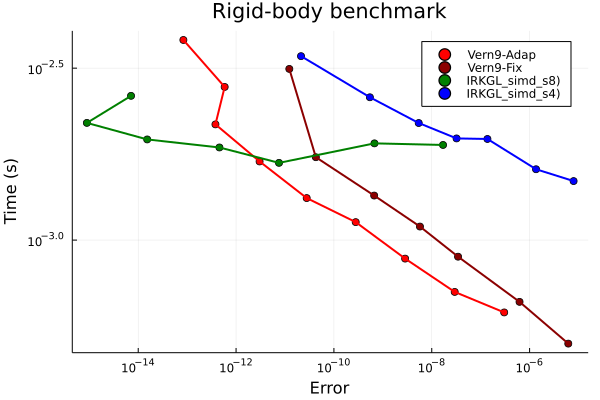

In [18]:
plot(title="Rigid-body benchmark",xlabel="Error", ylabel="Time (s)")
# 
plot!(wp1.errors, wp1.times, seriestype=:scatter, scale=:log10, label="Vern9-Adap",color="red")
plot!(wp1.errors, wp1.times, scale=:log10, label="", lw=2, color="red")
#
plot!(wp2.errors, wp2.times, seriestype=:scatter, scale=:log10, label="Vern9-Fix",color="Darkred")
plot!(wp2.errors, wp2.times, scale=:log10, label="", lw=2, color="Darkred")
#
#
plot!(wp3.errors, wp3.times, seriestype=:scatter, scale=:log10, label="IRKGL_simd_s8)",color="green")
plot!(wp3.errors, wp3.times, scale=:log10, label="", lw=2, color="green")
#
#
plot!(wp4.errors, wp4.times, seriestype=:scatter, scale=:log10, label="IRKGL_simd_s4)",color="blue")
plot!(wp4.errors, wp4.times, scale=:log10, label="", lw=2, color="blue")